In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
data_path = "/content/drive/MyDrive/산데과/gear"

In [45]:
# 학습 데이터 전처리 모듈

class ImageLoader(Dataset):
    
    def read_data_set(self):
        all_img_files = []      
        all_labels = []
        class_names = os.walk(self.data_set_path).__next__()[1]
        print(class_names)

        for index, class_name in enumerate(class_names):
            
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                
                if img is not None:
                  all_img_files.append(img_file)
                  all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        
        image = Image.open(self.image_files_path[index])
        #image = Image.convert("RGB")

        if self.transforms is not None:
          image = self.transforms(image)

        return {'image': image, 'label': self.labels[index]}

    def __len__(self):
        return self.length

In [46]:
TransformsTrain = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])])
   
TransformsTest = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])])

TrainDataSet = ImageLoader("/content/drive/MyDrive/산데과/gear/train", 
                                              transforms=TransformsTrain)

TrainLoader = DataLoader(TrainDataSet, batch_size=8, shuffle=True)
TestDataSet = ImageLoader("/content/drive/MyDrive/산데과/gear/test", 
                                             transforms=TransformsTest)

TestLoader = DataLoader(TestDataSet, batch_size=8, shuffle=True)

['good', 'error']
['good', 'error']


In [69]:
# CNN 네트워크 구조 정의

class cnn(nn.Module):
  
  def __init__(self, input_dim, hid_dim, out_dim):
    super(cnn, self).__init__()
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.out_dim = out_dim
    self.conv_block1 = self.conv_block(input_dim, hid_dim)
    self.conv_block2 = self.conv_block(hid_dim, hid_dim*2)
    self.conv_block3 = self.conv_block(hid_dim*2, hid_dim*4)
    self.conv_block4 = self.conv_block(hid_dim*4, hid_dim*8)
    self.conv_block5 = self.conv_block(hid_dim*8, hid_dim*4)
    self.conv_block6 = self.conv_block(hid_dim*4, hid_dim*2)
    self.final_block = self.avg_block(hid_dim*2, out_dim)

  def forward(self, x):
    out = self.conv_block1(x)
    out = self.conv_block2(out)
    out = self.conv_block3(out)
    out = self.conv_block4(out)
    out = self.conv_block5(out)
    out = self.conv_block6(out)
    out = self.final_block(out)
    out = out.view(-1, self.out_dim)
    return out

  def conv_block(self, in_size, out_size):
    return nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_size),
        nn.ReLU(),
        nn.Dropout(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  def avg_block(self, in_size, out_size):
    return nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_size),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1))
    )

In [70]:
model = cnn(3,32,2).cuda()#out은 good,bad 두 개이기에

In [71]:
loss = nn.CrossEntropyLoss()#Binary_CrossEntropy를 쓰려면 final activation이 sigmoid가 되야함
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [72]:
losses = []
for e in range(1000):

  for i_batch, item in enumerate(TrainLoader):
    images = item['image'].cuda()
    labels = item['label'].cuda()

    outputs = model(images)
    L = loss(outputs,labels)
    losses.append(L.item())
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
  if (e+1)%100 == 0:
    print('[Epoch: {}/{}], [Loss: {:.4f}]'.format(e + 1, 1000, L.item()))

[Epoch: 100/1000], [Loss: 0.6529]
[Epoch: 200/1000], [Loss: 0.4914]
[Epoch: 300/1000], [Loss: 0.2122]
[Epoch: 400/1000], [Loss: 0.3067]
[Epoch: 500/1000], [Loss: 0.0594]
[Epoch: 600/1000], [Loss: 0.2169]
[Epoch: 700/1000], [Loss: 0.2072]
[Epoch: 800/1000], [Loss: 0.5156]
[Epoch: 900/1000], [Loss: 0.1915]
[Epoch: 1000/1000], [Loss: 0.0146]


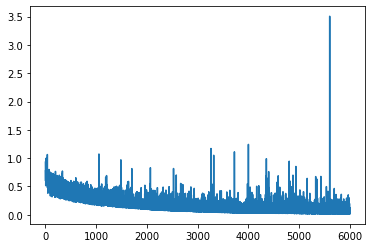

In [74]:
plt.plot(losses)

In [73]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for item in TestLoader:
      images = item['image'].cuda()
      labels = item['label'].cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += len(labels)
      correct += (predicted == labels).sum().item()

print('[Test Accuracy: {:4f}]'.format(100 * correct / total))
#기존 50프로에서 52프로로 상승

[Test Accuracy: 52.272727]
